# Mémoire

In [1]:
from Basic_Model import *
from Newton import *

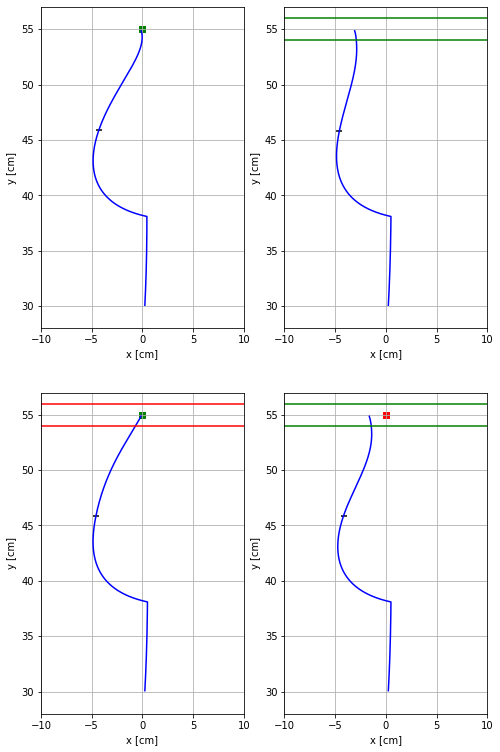

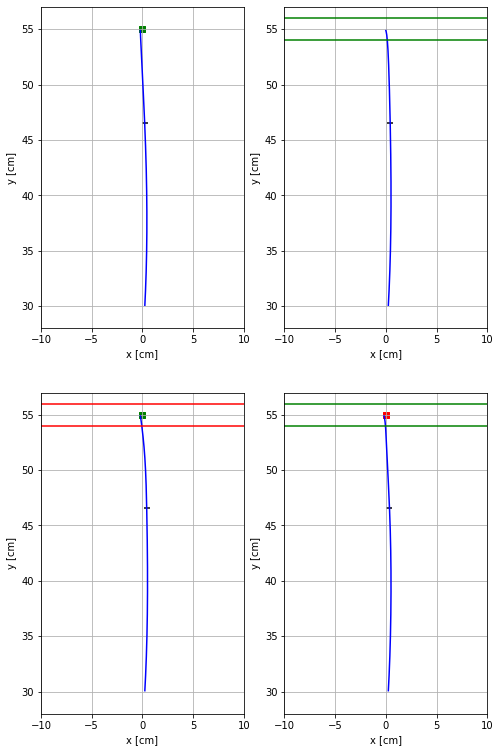

In [19]:
def Simulation_Mec(tau,w1,w2,w3,w4,wt,r1,r2,trial_type = "rr"):
    DELAYED_RESPONSE = 500
    Num_iter = 500
    dt = 0.001
    obj1,obj2 = newton(f,df,1e-8,1000,0,55)
    xstart = np.array([0.4,0,0,2.15,0,0,obj1,0,0,obj2,0,0,0,0])
    x0 = np.array([0.4,0,0,2.15,0,0,obj1,0,0,obj2,0,0,0,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[9]]),np.array(x0[12:])))
    Bruit = True
    NbreVar = 10
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Q = np.array([[wt/2+w1,0,0,-2*wt,0,0,wt-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [-2*wt,0,0,2*wt+w2,0,0,-wt,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [wt-w1,0,0,-wt,0,0,w1+wt,0],[0,0,0,-w2,0,0,0,w2]])
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    Qnonlin = np.zeros((10,10))
    Qnonlin[:8,:8] = Q
    
    
    #Define Dynamic Matrices  
    Az = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    newAz = np.zeros((10,10))
    newAz[:8,:8] = Az
    Az = newAz
    Bz = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0],[0,0],[0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    #Az = (Az - np.identity(NbreVar))/dt
    #Az[8,8] = 0
    #Az[9,9] = 0
    #Bz = Bz/dt
    S = Qnonlin
    s = 0
    array_L = np.zeros((Num_iter-1,2,NbreVar))    
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+Bz.T@S@Bz)@Bz.T@S@Az
        array_L[Num_iter-2-k] = L
        S = Az.T@S@(Az-Bz@L)
    
    #print(array_L[0])
    #Feedback
    #Az = Az*dt + np.identity(NbreVar)
    #Az[8,8] = 0
    #Az[9,9] = 0
    #Bz = Bz*dt
    H,L,x0,A,B = np.identity(10),array_L,xnonlin0,Az,Bz
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2))
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat
    step = False
    for k in range(Num_iter-1):
        if trial_type != "ss":
            #thetas = Symbol("thetas")
            #thetae = Symbol("thetae")
            
            nowX = np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30
            if trial_type == "rs" and k > DELAYED_RESPONSE and step == 1:
                nowX = 0
            if trial_type == "sr" and k < DELAYED_RESPONSE and step == 1:
                nowX = 0
            #print(nowX)
            solts,solte = newton(f,df,1e-8,1000,nowX,55,x0 = np.array([x[6],x[7]]))
            #sol = solve([33*sym.cos(thetas+thetae)+30*sym.cos(thetas)-nowX,33*sym.sin(thetas+thetae)+30*sym.sin(thetas)-55],thetas,thetae)
            #print(sol[0])
            x[6] = solts
            x[7] = solte
            xhat[6] = solts
            xhat[7] = solte
            y[k][6] = solts
            y[k][7] = solte
        #print(reelx[2],array_reelx[k-1][2])
        #x[0],x[1],x[3],x[4],x[2],x[5] = reelx[0],reelx[2],reelx[1],reelx[4],(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt
        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        v = -L[k].reshape(np.flip(B.shape))@xhat
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]+reelx[6:8]-Bdyn@(reelx[2:4])-C))
            
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
    
        u = 1/K*M@v-1/K*M@Minvdot@M@np.array([x[2],x[5]])+M@np.array([x[2],x[5]])+C+Bdyn@np.array([x[1],x[4]])+1/K*Cdot+1/K*Bdyn@np.array([x[2],x[5]])+x[8:10]
        #print(u)
        if step == 1:
            new_reelx[6:8] = 0
            x[8:10],y[k][8:10],xhat[8:10] = np.zeros(2),np.zeros(2),np.zeros(2)
        if (np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 38 and step == 0:
            if DELAYED_RESPONSE == 500:
                DELAYED_RESPONSE = k + 100
            step = 1
            new_reelx[6:8] = tau
            x[8:10] = tau
            xhat[8:10] = tau
            y[k+1][8:10] = tau
        new_reelx[4:6] += dt*K*(u-reelx[4:6]-reelx[6:8])
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx    

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]
    ax[U1,U2].plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "blue")
    if trial_type == "rs" or trial_type == "rr" or trial_type == "sr":
        PLOT_COLOR = "green"
        if trial_type == "rs":
            PLOT_COLOR = "red"
        ax[U1,U2].plot(np.linspace(-10,10,1000),np.ones(1000)*54,color = PLOT_COLOR)
        ax[U1,U2].plot(np.linspace(-10,10,1000),np.ones(1000)*56,color = PLOT_COLOR)
    if trial_type == "ss"  or trial_type == "rs" or trial_type == "sr": 
        PLOT_COLOR = "green"
        if trial_type == "sr":
            PLOT_COLOR = "red"
        ax[U1,U2].scatter(np.cos(x0[6]+x0[9])*33+np.cos(x0[6])*30,np.sin(x0[9]+x0[6])*33+np.sin(x0[6])*30,color = PLOT_COLOR,marker = "s")
    ax[U1,U2].scatter(np.cos(reelx[0][DELAYED_RESPONSE]+reelx[1][DELAYED_RESPONSE])*33+np.cos(reelx[0][DELAYED_RESPONSE])*30,np.sin(reelx[0][DELAYED_RESPONSE]+reelx[1][DELAYED_RESPONSE])*33+np.sin(reelx[0][DELAYED_RESPONSE])*30,color = "black",marker = "_")
    

    #axis = plt.gca()
    #axis.set_aspect('equal', adjustable='box')
    
    ax[U1,U2].set_xlabel("x [cm]")
    ax[U1,U2].set_ylabel("y [cm]")
    ax[U1,U2].grid()
    
    ax[U1,U2].set_xlim(-10,10)
    ax[U1,U2].set_ylim(28,57)
    
    
    #plt.legend()


#for perturbation in [np.array([300,150]),np.array([-300,0]),np.array([500,250]),np.array([-600,0])]: 

for perturbation in [np.array([600,200]),np.array([0,0])]:
    U1,U2 = [0,0]
    fig,ax = plt.subplots(2,2,figsize = (8,13))

    Simulation_Mec(perturbation,100000,100000,1000,1000,0,0.000001,0.000001,trial_type = "ss")
    U1,U2=[0,1]
    Simulation_Mec(perturbation,100000,100000,1000,1000,0,0.000001,0.000001,trial_type = "rr")
    U1,U2=[1,0]
    Simulation_Mec(perturbation,100000,100000,1000,1000,0,0.000001,0.000001,trial_type = "rs")
    U1,U2=[1,1]
    Simulation_Mec(perturbation,100000,100000,1000,1000,0,0.000001,0.000001,trial_type = "sr")
    if perturbation[0] == 0:
        plt.savefig("PLOTS/nopert.pdf")
    else : plt.savefig("PLOTS/pert.pdf")
    plt.show()

